In [12]:
import geopandas
import rioxarray
import shapely
import pdal
import numpy
import json
import pathlib
import pdal
import time
import matplotlib
import matplotlib.pyplot

# The NZ20_Westport produces a 15m offset
Dataset information: https://doi.org/10.5069/G9Z31WV0

Datum information:

    Horizontal: NZTM2000 NZGD2000 Meters [EPSG: 2193]
    Vertical: NZVD2016 [EPSG: 7839]

In [7]:
tile = "CL2_BR20_2020_1000_3731.laz"

In [8]:
file_path = pathlib.Path(r'C:\Users\pearsonra\Documents\data\Westport\local_cache\NZ20_Westport') / tile

In [38]:
h_crs = 2193
v_crs = 7839

In [74]:
pdal_pipeline_instructions = [{"type":"readers.las", "filename": str(file_path)},
                              {"type":"filters.reprojection","out_srs":"EPSG:" + str(h_crs)}, 
                              {"type":"filters.hexbin"}]
pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute()
metadata_hproj=json.loads(pdal_pipeline.get_metadata())
extent_hproj = shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])
points_hproj = pdal_pipeline.arrays

In [75]:
pdal_pipeline_instructions = [{"type":"readers.las", "filename": str(file_path)},
                              {"type":"filters.reprojection","out_srs":"EPSG:" + str(v_crs)}, 
                              {"type":"filters.hexbin"}]
pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute()
metadata_vproj=json.loads(pdal_pipeline.get_metadata())
extent_vproj = shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])
points_vproj = pdal_pipeline.arrays

In [76]:
pdal_pipeline_instructions = [{"type":"readers.las", "filename": str(file_path)},
                              {"type":"filters.hexbin"}]
pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute()
metadata_noproj=json.loads(pdal_pipeline.get_metadata())
extent_noproj = shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])
points_noproj = pdal_pipeline.arrays

C:\ProgramData\Anaconda3\envs\spyder\lib\site-packages\geopandas\plotting.py:407: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

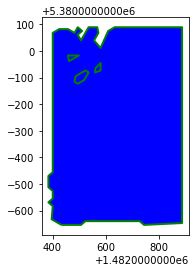

In [54]:
ax = geopandas.GeoSeries(extent_hproj).plot(color='blue')
geopandas.GeoSeries(extent_vproj).plot(ax=ax, color='none', edgecolor='red', linewidth=4)
geopandas.GeoSeries(extent_noproj).plot(ax=ax, color='none', edgecolor='green', linewidth=2)


In [49]:
metadata['metadata'].keys()

dict_keys(['filters.hexbin', 'filters.reprojection', 'readers.las'])

# Compare the points returned for the different reprojections
Note that: 
1. The EPSG:2193 (horizontal) produces an incorrect vertical offset
2. The EPSG:7839 (vertical) results in no points returned
3. No projection seems to produce correct value

Consider chaining and checking projects and only performing projection if not already in the desired EPSG. **Will need to apply clipping after as will beed to check the points are in the right datum.**

In [77]:
points_hproj

[array([(1482400.59, 5379360.19, 15.1187161 , 320, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.1 , 5379360.7 , 15.09769989, 368, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.07, 5379363.16, 15.12770089, 336, 1, 1, 0, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        ...,
        (1482400.15, 5379360.96, 15.0887018 , 576, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482400.67, 5379360.62, 15.11671917, 528, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482401.2 , 5379360.26, 15.08573686, 736, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('ClassFlags', 'u1')])]

In [78]:
points_vproj

[array([],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('ClassFlags', 'u1')])]

In [79]:
points_noproj

[array([(1482400.59, 5379360.19, -0.948, 320, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.1 , 5379360.7 , -0.969, 368, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.07, 5379363.16, -0.939, 336, 1, 1, 0, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        ...,
        (1482400.15, 5379360.96, -0.978, 576, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482400.67, 5379360.62, -0.95 , 528, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482401.2 , 5379360.26, -0.981, 736, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('ClassFlags', 'u1')])]

# Look at meta data to look for CRS
Note the `comp_spatialreference` and `spatialreference` are the same. The `srs` appears to indicate the transform applied. Could look at carefully to try inderstnd the vertical offset.

In [80]:
metadata_hproj['metadata'].keys()

dict_keys(['filters.hexbin', 'filters.reprojection', 'readers.las'])

In [81]:
metadata_hproj['metadata']['filters.reprojection'].keys()

dict_keys(['comp_spatialreference', 'spatialreference', 'srs'])

In [83]:
metadata_hproj['metadata']['filters.reprojection']['comp_spatialreference'] == metadata_hproj['metadata']['filters.reprojection']['spatialreference']

True

In [85]:
metadata_hproj['metadata']['filters.reprojection']['srs'].keys()

dict_keys(['compoundwkt', 'horizontal', 'isgeocentric', 'isgeographic', 'prettycompoundwkt', 'prettywkt', 'proj4', 'units', 'vertical', 'wkt'])

In [88]:
metadata_hproj['metadata']['filters.reprojection']['srs']

{'compoundwkt': 'PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]',
 'horizontal': 'PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG",

# Look at Metadata to identify horizontal and vertical information

In [89]:
metadata['metadata']['readers.las'].keys()

dict_keys(['comp_spatialreference', 'compressed', 'count', 'creation_doy', 'creation_year', 'dataformat_id', 'dataoffset', 'filesource_id', 'global_encoding', 'global_encoding_base64', 'header_size', 'major_version', 'maxx', 'maxy', 'maxz', 'minor_version', 'minx', 'miny', 'minz', 'offset_x', 'offset_y', 'offset_z', 'point_length', 'project_id', 'scale_x', 'scale_y', 'scale_z', 'software_id', 'spatialreference', 'srs', 'system_id', 'vlr_0', 'vlr_1', 'vlr_2'])

In [101]:
metadata['metadata']['readers.las']['spatialreference']

'COMPD_CS["NZGD2000 / New Zealand Transverse Mercator 2000 + NZVD2016 height",PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]],VERT_CS["NZVD2016 height",VERT_DATUM["New Zealand Vertical Datum 2016",2005,AUTHORITY["EPSG","1169"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","7839"]]]'

In [100]:
metadata['metadata']['readers.las']['spatialreference'] == metadata['metadata']['readers.las']['comp_spatialreference']

True

In [104]:
metadata['metadata']['readers.las']['srs'].keys()

dict_keys(['compoundwkt', 'horizontal', 'isgeocentric', 'isgeographic', 'prettycompoundwkt', 'prettywkt', 'proj4', 'units', 'vertical', 'wkt'])

In [105]:
metadata['metadata']['readers.las']['srs']['horizontal']

'PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]'

In [106]:
metadata['metadata']['readers.las']['srs']['vertical']

'VERT_CS["NZVD2016 height",VERT_DATUM["New Zealand Vertical Datum 2016",2005,AUTHORITY["EPSG","1169"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","7839"]]'

In [122]:
vertical_srs = metadata['metadata']['readers.las']['srs']['vertical']

In [140]:
vertical_srs[vertical_srs.rfind('AUTHORITY["EPSG",'):].strip('AUTHORITY["EPSG",""').strip('"]]')

'7839'

In [134]:
list(filter(str.isdigit, str1))

['7', '8', '3', '9']

In [118]:
metadata['metadata']['readers.las']['srs']['wkt']

'PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]'

# Try reprojection again with different 
Examples of pitfalls: https://pdal.io/workshop/exercises/translation/reprojection.html

In [109]:
pdal_pipeline_instructions = [{"type":"readers.las", "filename": str(file_path)},
                              {"type":"filters.reprojection","in_srs":"EPSG:" + str(h_crs), "out_srs":"EPSG:" + str(h_crs)}, 
                              {"type":"filters.hexbin"}]
pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
pdal_pipeline.execute()
metadata_hproj=json.loads(pdal_pipeline.get_metadata())
extent_hproj = shapely.wkt.loads(metadata['metadata']['filters.hexbin']['boundary'])
points_hproj = pdal_pipeline.arrays

In [110]:
points_hproj

[array([(1482400.59, 5379360.19, -0.948, 320, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.1 , 5379360.7 , -0.969, 368, 1, 1, 1, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        (1482400.07, 5379363.16, -0.939, 336, 1, 1, 0, 0, 2, -16.002, 0, 60, 2.77509272e+08, 0, 0),
        ...,
        (1482400.15, 5379360.96, -0.978, 576, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482400.67, 5379360.62, -0.95 , 528, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0),
        (1482401.2 , 5379360.26, -0.981, 736, 1, 1, 1, 0, 2,  -3.   , 0, 62, 2.77508538e+08, 0, 0)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8'), ('ScanChannel', 'u1'), ('ClassFlags', 'u1')])]

In [141]:
metadata_hproj['metadata']['readers.las']['srs']['horizontal']

'PROJCS["NZGD2000 / New Zealand Transverse Mercator 2000",GEOGCS["NZGD2000",DATUM["New_Zealand_Geodetic_Datum_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6167"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4167"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",173],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",1600000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2193"]]'

In [142]:
metadata_hproj['metadata']['readers.las']['srs']['vertical']

'VERT_CS["NZVD2016 height",VERT_DATUM["New Zealand Vertical Datum 2016",2005,AUTHORITY["EPSG","1169"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","7839"]]'

In [145]:
'123'.isdigit()

True